In [15]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click </i> <a href="javascript:code_toggle()">here</a>.''')

# HOC using a Random Forest

## LES Dataset

3D simulations were run for the BOMEX (nonprecipitating shallow cumulus) case by Peter Blossey. There is a 3D snapshot every 15 minutes. I copied and extracted the archived data, and derived new datasets including only vertical velocity, liquid water potential temperature, and total water. Note that precipitating water is not counted for total water in this case, but this shouldn't matter (since this is a nonprecipitating shallow cumulus case). I also assume that all non-precipitating condensate is water (even though this output includes ice), with the reasoning that ice cloud should not be present in the BOMEX case.

 Liquid water potential temperature is determined using the approximation $$\theta_l \approx \theta - \frac{L_v}{c_{pd}} r_L$$

Where the latent heat of vaporizaton of water $L_v$ is taken to be its value at 0 Celcius (2.501 x 10^6 J/kg), and $\theta$ is potential temperature, given by $$\theta = T (\frac{P_0}{P})^{R_d/{c_{pd}}}$$ where $P$ is pressure and $P_0$ is reference pressure (10^5 Pa).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from subprocess import call
from tempfile import TemporaryFile
from glob import glob
import os
%matplotlib inline

In [2]:
Lv0 = 2.501e6  # Latent heat of vaporization for water at 0 Celsius (J/kg)
Cpd = 1005.  # Specific heat of dry air at constant pressure (J/kg/K)

def derive_hoc_dataset(original_dataset):
    """Takes in an xarray Dataset containing SAM 3D snapshot output, and returns a dataset
       containing liquid water potential temperature, total water mixing ratio, and
       vertical velocity in addition to the original variables.
    """
    dataset = original_dataset.copy(deep=True)
    theta = dataset['TABS'] * (1e3 / dataset['p']) ** (2./7.)  # SAM gives pressure in hPa
    dataset['thetal'] = theta - Lv0/Cpd * dataset['QN'] * 1e-3  # SAM gives QN in g/kg
    dataset['thetal'].attrs['units'] = 'K'
    dataset['thetal'].attrs['long_name'] = 'liquid water potential temperature'
    dataset['qt'] = dataset['Q'] + dataset['QN']
    dataset['qt'].attrs['units'] = 'g/kg'
    dataset['qt'].attrs['long_name'] = 'total water mixing ratio'
    dataset.rename({'W': 'w'}, inplace=True)
    return dataset

In [3]:
archive_folder = '/home/disk/eos1/bloss/Runs/BOMEX/DATA3D/'
netcdf_folder = '/home/disk/eos4/mcgibbon/nobackup/HOC/data/BOMEX/'

In [ ]:
for gzipped_filename in glob(archive_folder + '*sst_bmx3_16_*.nc.gz'):
    netcdf_filename = gzipped_filename[:-3].replace(archive_folder, netcdf_folder)  # remove the '.gz', switch folder
    if not os.path.isfile(netcdf_filename):  # check if the file has already been processed
        with open(netcdf_filename, 'w') as output_file:
            #print('Unzipping {} to {}'.format(gzipped_filename, netcdf_filename))
            call(['gunzip', '-c', gzipped_filename], stdout=output_file)
        with xr.open_dataset(netcdf_filename) as original_dataset:
            new_dataset = derive_hoc_dataset(original_dataset)
            new_dataset.drop(['U', 'V', 'TABS'])
        new_dataset.to_netcdf(netcdf_filename, mode='w')  # overwrite the copied dataset

With this pre-processing step complete, I derived a dataset with the statistical moments and parameters that will be used as input and outputs for the neural network. Input moments are the same as have been used to fit the Lewellen-Yoh joint double Gaussian PDF: $\overline{w}$, $\overline{w'^2}$, $\overline{w'^3}$, $\overline{\theta_l}$, $\overline{\theta_l'^2}$, $\overline{\theta_l'^3}$, $\overline{q_t}$, $\overline{q_t'^2}$, $\overline{q_t'^3}$, $\overline{w'q_t'}$, $\overline{w'\theta_l'}$, and $\overline{q_t'\theta_l'}$. For this initial test, only mean liquid water, $\overline{q_l}$, and vertical advection of liquid water, $\overline{w'q_l'}$, will be used as outputs. SAM's "nonprecipitating water" is used as a measure of liquid water.

In [ ]:
def get_moments(array, n_max=3):
    """Takes in a DataArray and returns its statistical moments up to order n_max."""
    mean = array.mean(dim=('nx', 'ny'))
    return_list = [mean]
    perturbation = array - mean
    for moment_order in range(2, n_max+1):
        return_list.append((perturbation**moment_order).mean(dim=('nx', 'ny')))
    return return_list

def get_eddy_covariance(*arrays):
    """Takes in two (or more) DataArrays and returns bar(array1' * array2' * ...)"""
    means = [array.mean(dim=('nx', 'ny')) for array in arrays]
    perturbations = [arrays[i] - means[i] for i in range(len(arrays))]
    product = perturbations[0] * 0. + 1.
    for perturbation in perturbations:
        product *= perturbation
    return product.mean(dim=('nx', 'ny'))

In [ ]:
snapshot_filenames = glob(netcdf_folder + '*sst_bmx3_16_*.nc')
with xr.open_dataset(snapshot_filenames[0]) as sample_snapshot:
    z = sample_snapshot['z'].copy(deep=True)

ntime = len(snapshot_filenames)
nz = len(z)
time = np.zeros([ntime])

base_vars = ['w', 'thetal', 'qt']

output_moments = []
for base_varname in base_vars:
    # want variable names for the mean, second moment, and third moment
    output_moments.extend([base_varname, base_varname + '2', base_varname + '3', base_varname + '4'])

data = {}
for varname in output_moments + ['w_qt', 'w_thetal', 'qt_thetal', 'ql', 'w_ql', 'w_qt2',
                                 'w_thetal2', 'w_qt_thetal', 'w2_thetal', 'w2_qt']:
    data[varname] = np.zeros([ntime, nz])

for it, snapshot_filename in enumerate(snapshot_filenames):
    with xr.open_dataset(snapshot_filename, chunks={'nz': 16}) as snapshot:
        for base_varname in base_vars:
            v, v2, v3, v4 = get_moments(snapshot[base_varname], n_max=4)
            data[base_varname][it, :] = v
            data[base_varname + '2'][it, :] = v2
            data[base_varname + '3'][it, :] = v3
            data[base_varname + '4'][it, :] = v4
            time[it] = snapshot['time'][0]

        data['w_qt'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['qt'])
        data['w_thetal'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['thetal'])
        data['qt_thetal'][it, :] = get_eddy_covariance(snapshot['qt'], snapshot['thetal'])
        data['w_qt2'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['qt'], snapshot['qt'])
        data['w_thetal2'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['thetal'], snapshot['thetal'])
        data['w_qt_thetal'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['qt'], snapshot['thetal'])
        data['w2_thetal'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['w'], snapshot['thetal'])
        data['w2_qt'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['w'], snapshot['qt'])
        
        data['ql'][it, :] = get_moments(snapshot['QN'], n_max=1)[0]
        data['w_ql'][it, :] = get_eddy_covariance(snapshot['QN'], snapshot['w'])

In [ ]:
coords = {'time': (['time'], time), 'z': (['z'], z)}
data_vars = {}
for varname in data:
    data_vars[varname] = (['time', 'z'], data[varname])
ds = xr.Dataset(data_vars, coords=coords)
ds.to_netcdf(os.path.join(netcdf_folder, 'moments.nc'))

Data was normalized to lie between 0 and 1, based on the full dataset.

In [4]:
ds = xr.open_dataset(os.path.join(netcdf_folder, 'moments.nc'))
num_samples = len(ds['time'])*len(ds['z'])

input_parameters = ['w', 'w2', 'w3', 'thetal', 'thetal2', 'thetal3', 'qt', 'qt2', 'qt3', 'w_thetal', 'w_qt', 'qt_thetal']
output_parameters = ['ql', 'w_ql', 'w_qt2', 'w_thetal2', 'w4', 'qt4', 'thetal4', 'w_qt_thetal', 'w2_qt', 'w2_thetal']

#input_parameters = ['w', 'thetal', 'qt', 'w_thetal', 'w_qt', 'qt_thetal']
#output_parameters = ['w2', 'thetal2', 'qt2', 'w_thetal', 'w_qt', 'ql']

model_input = np.zeros([num_samples, len(input_parameters)])
model_output = np.zeros([num_samples, len(output_parameters)])

for i, input_parameter in enumerate(input_parameters):
    model_input[:, i] = ds[input_parameter].values.reshape([num_samples])

for i, output_parameter in enumerate(output_parameters):
    model_output[:, i] = ds[output_parameter].values.reshape([num_samples])

In [5]:
def get_normalization(data):
    min_value = data.min(axis=0)
    max_value = data.max(axis=0)
    def normalize(data):
        return (data - min_value)/(max_value - min_value)
    def denormalize(data):
        return data * (max_value - min_value) + min_value
    return normalize, denormalize

normalize_input, denormalize_input = get_normalization(model_input)
normalize_output, denormalize_output = get_normalization(model_output)
model_input = normalize_input(model_input)
model_output = normalize_output(model_output)

80% of the data was used for training the model, while 20% was reserved for validation. Training data was chosen at random.

In [6]:
np.random.seed(0)  # seed so results are reproduceable

total_samples = model_input.shape[0]
training_proportion = 0.8
training_samples = int(training_proportion*total_samples)
training_indices = np.random.choice(range(total_samples), size=training_samples, replace=False)
test_indices = list(set(range(total_samples)).difference(training_indices))

training_input = model_input[training_indices, :]
training_output = model_output[training_indices, :]
test_input = model_input[test_indices, :]
test_output = model_output[test_indices, :]

## Fitting a Random Forest

With statistical moments in hand, I defined a random forest to fit. Scikit-learn was used for this purpose.

In [7]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(0)  # seed so results are reproduceable
model = RandomForestRegressor(
    n_estimators=100, min_samples_leaf=4, max_features=3, max_depth=None, bootstrap=True).fit(
        training_input, training_output)

Having fit the random forest to the training data, I tested it on the testing data and the training data. For each model output parameter (row), we see a histogram of the model error on the test data (left) and the training data (center), as well as the variability in the LES values used for training (right).

In [8]:
modeled_test_values = denormalize_output(model.predict(test_input))
actual_test_values = denormalize_output(test_output)
modeled_training_values = denormalize_output(model.predict(training_input))
actual_training_values = denormalize_output(training_output)

ql test bias: -2.82e-06, RMSE: 9.54e-04, real STD: 5.73e-03, percent: 16.7
w_ql test bias: -6.37e-07, RMSE: 8.03e-04, real STD: 9.96e-03, percent: 8.1
w_qt2 test bias: -3.19e-04, RMSE: 1.77e-02, real STD: 1.41e-01, percent: 12.6
w_thetal2 test bias: -1.44e-04, RMSE: 1.32e-02, real STD: 8.83e-02, percent: 14.9
w4 test bias: -7.65e-03, RMSE: 3.95e-01, real STD: 1.65e+00, percent: 24.0
qt4 test bias: -9.79e-03, RMSE: 5.15e-01, real STD: 4.27e+00, percent: 12.1
thetal4 test bias: -1.30e-03, RMSE: 3.88e-01, real STD: 3.26e+00, percent: 11.9
w_qt_thetal test bias: 2.12e-04, RMSE: 1.44e-02, real STD: 1.07e-01, percent: 13.4
w2_qt test bias: -4.12e-04, RMSE: 2.87e-02, real STD: 1.90e-01, percent: 15.1
w2_thetal test bias: 1.46e-04, RMSE: 2.26e-02, real STD: 1.42e-01, percent: 15.9


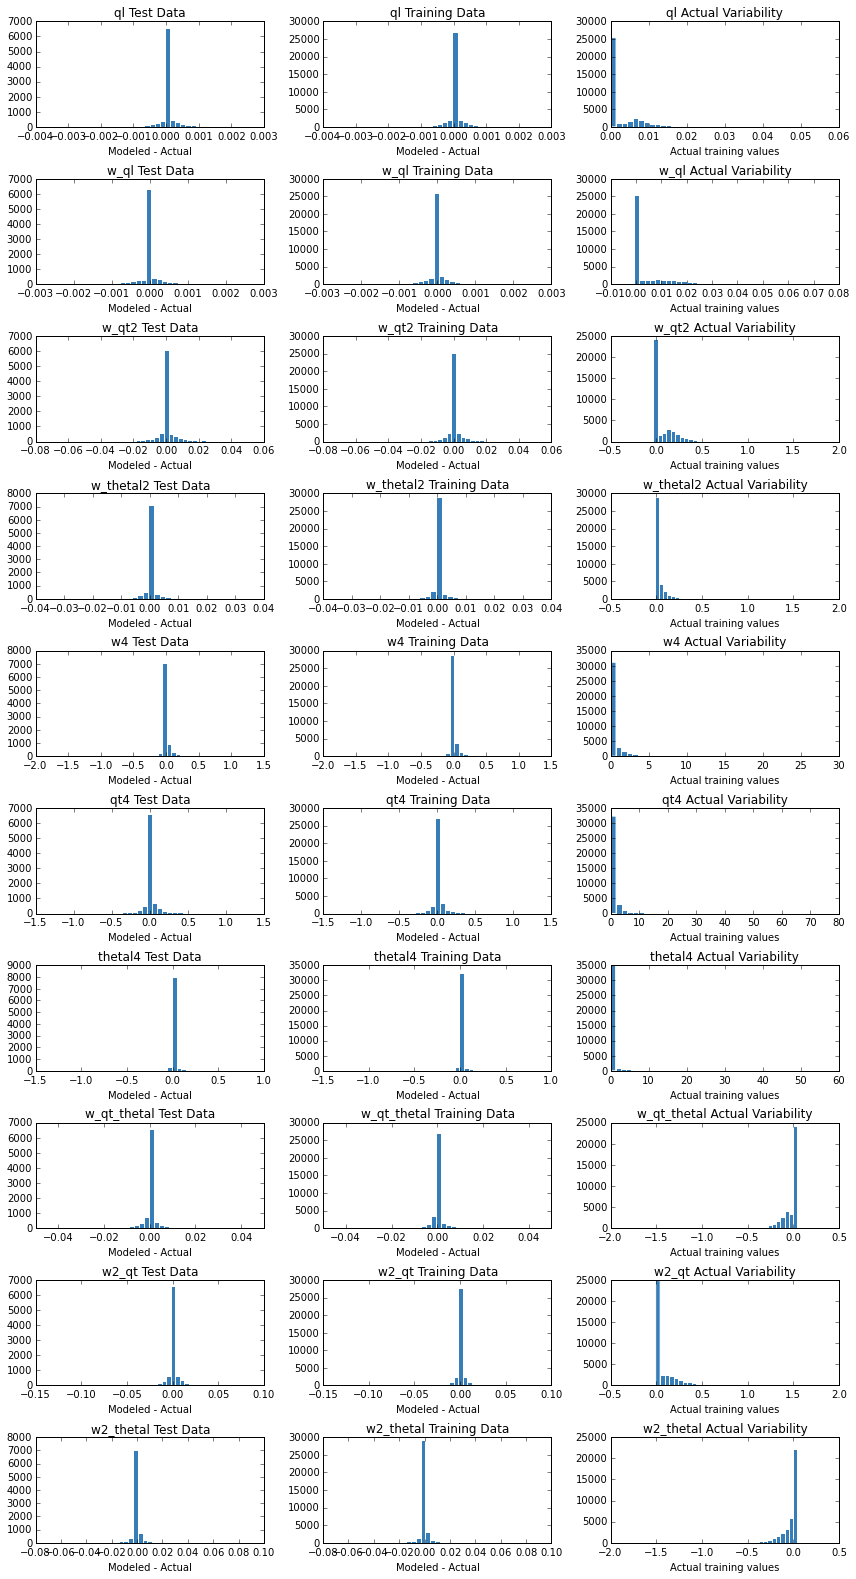

In [9]:
fig, ax = plt.subplots(len(output_parameters), 3, figsize=(12, 2*len(output_parameters) + 2))
for i in range(len(output_parameters)):
    name = output_parameters[i]
    
    test_errors = modeled_test_values[:, i] - actual_test_values[:, i]
    v_min, v_max = np.percentile(test_errors, 1), np.percentile(test_errors, 99)
    
    ax[i, 0].hist(test_errors, bins=np.linspace(v_min, v_max, 40))
    ax[i, 0].set_xlabel('Modeled - Actual')
    ax[i, 0].set_title('{} Test Data'.format(name))

    training_errors = modeled_training_values[:, i] - actual_training_values[:, i]
    ax[i, 1].hist(training_errors, bins=np.linspace(v_min, v_max, 40))
    ax[i, 1].set_xlabel('Modeled - Actual')
    ax[i, 1].set_title('{} Training Data'.format(name))

    ax[i, 2].hist(actual_training_values[:, i], bins=40)
    ax[i, 2].set_xlabel('Actual training values')
    ax[i, 2].set_title('{} Actual Variability'.format(name))

    print('{} test bias: {:.2e}, RMSE: {:.2e}, real STD: {:.2e}, percent: {:.1f}'.format(
        name, test_errors.mean(),
        test_errors.std(), actual_test_values[:, i].std(),
        test_errors.std()/actual_test_values[:, i].std()*100.))

plt.tight_layout()
plt.show()

We can look at a random point in time to compare the model to the LES. For $\overline{w'^4}$ we also have the result from fitting to the Analytic Double Gaussian 1 used in CLUBB.

In [10]:
ADG1 = {}
sigma_w = 0.4 * (ds['w2'])**0.5
Skw = ds['w3'] * ds['w2']**(3./2)
a = 0.5 * (1 - Skw * (4*(1 - sigma_w**2)**3 + Skw**2)**(-0.5))
w1_pert = ds['w2']**0.5 * ((1-a)/a)**0.5 * (1 - sigma_w**2)**0.5
w2_pert = ds['w2']**0.5 * -1 * (a/(1-a))**0.5 * (1 - sigma_w**2)**0.5
thetal1_pert = ds['thetal2']**0.5 * -1 * ds['w_thetal']/(ds['w2']**0.5 * ds['thetal2']**0.5) / (w2_pert / ds['w2']**0.5)
thetal2_pert = ds['thetal2']**0.5 * -1 * ds['w_thetal']/(ds['w2']**0.5 * ds['thetal2']**0.5) / (w1_pert / ds['w2']**0.5)
ADG1['w4'] = (a*(w1_pert**4 + 6* w1_pert**2*sigma_w**2 + 3*sigma_w**4) +
              (1-a)*(w2_pert**4 + 6*w2_pert**2*sigma_w**2 + 3*sigma_w**4))

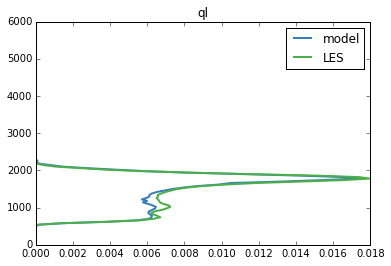

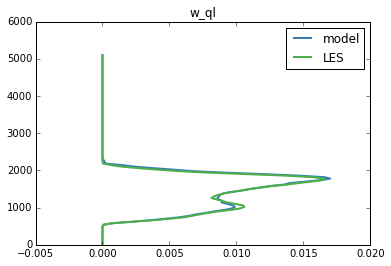

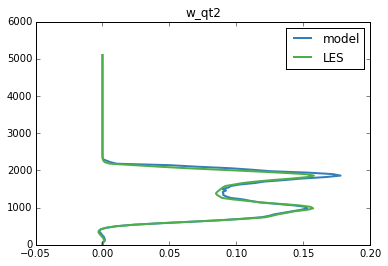

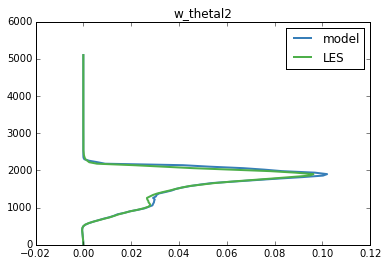

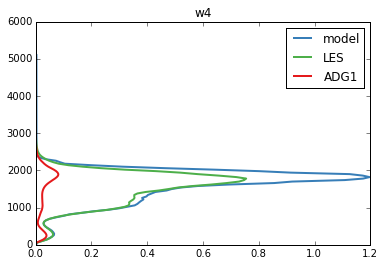

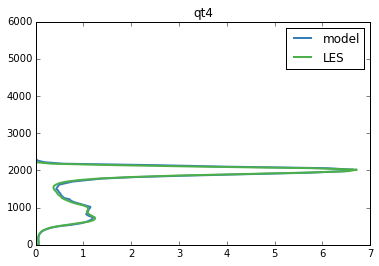

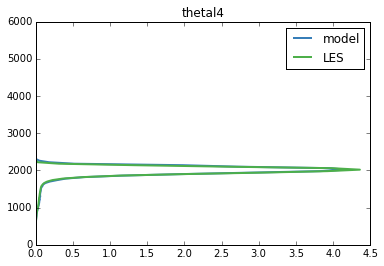

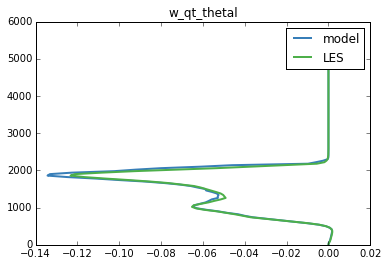

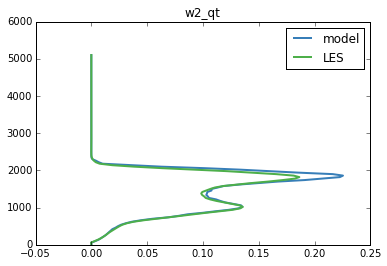

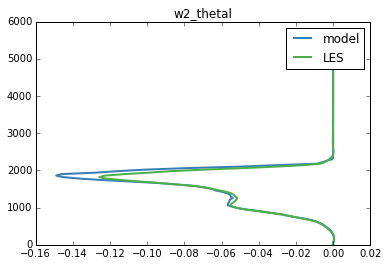

In [11]:
nt = len(ds['time'])
nz = len(ds['z'])
modeled_all_values = denormalize_output(model.predict(model_input)).reshape(nt, nz, model_output.shape[1])
actual_all_values = denormalize_output(model_output).reshape(nt, nz, model_output.shape[1])

it = np.random.randint(0, modeled_all_values.shape[0])

for i in range(len(output_parameters)):
    plt.figure()
    name = output_parameters[i]
    plt.title(name)
    plt.plot(modeled_all_values[it, :, i], ds['z'], label='model')
    plt.plot(actual_all_values[it, :, i], ds['z'], label='LES')
    if name in ADG1:
        plt.plot(ADG1[name][it, :], ds['z'], label='ADG1')
    plt.legend()
plt.show()

Expectedly, the model performs extremely well. In particular, it performs much better than the ADG1. Keep in mind, however, that this does not necessarily mean it will perform well for shallow cumulus in general, just for this particular case which has been used for training. It remains to be tested whether the model performs well for test cases that have not been involved in training.

A potential issue with the model is that the errors introduced are grid-scale. This high frequency variability in high-order moments may cause issues (or it may not, I haven't worked it out yet).

## Feature Importance

A benefit of random forests is that they allow us to investigate the importance of input features in determining predictands. The bar plot below shows the mean feature importance among all the trees in the forest, with the error bar showing the standard deviation. Note the PDFs of the importances are bimodal and non-gaussian. This can be seen in the second plot (which is quite hard to read, but it gets this one point across).

Nonetheless, we see that mean vertical velocity is irrelevant. This makes sense, since of course it should be 0 always. I took a mean value over a periodic domain. This feature will be removed in future trees.

We see interestingly that variance of liquid water is much less important than skewness in determining the higher order-moments, and that covariance of w and $\theta_l$ is very important.

To separate the importance of each input parameter on each output parameter, we could create a set of random forests, each with one output only. This is out of the scope of this current notebook.

/home/disk/p/mcgibbon/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


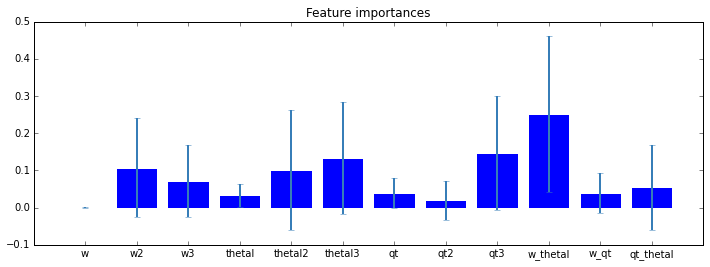

In [12]:
importances = model.feature_importances_
tree_feature_importances = np.asarray([tree.feature_importances_ for tree in model.estimators_])
std = np.std(tree_feature_importances, axis=0)
plt.figure(figsize=(12, 4))
plt.title('Feature importances')
plt.bar(range(len(input_parameters)), importances, yerr=std, align='center')
plt.xlim(-1, len(input_parameters))
plt.xticks(range(len(input_parameters)), input_parameters)
plt.show()

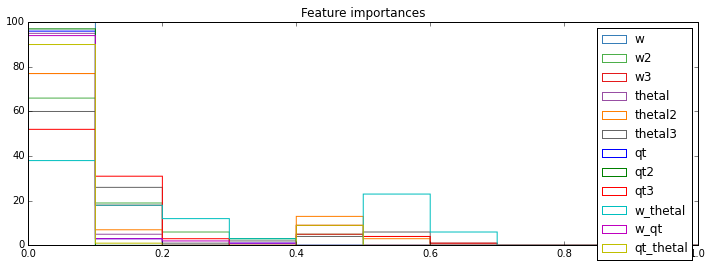

In [13]:
plt.figure(figsize=(12, 4))
plt.title('Feature importances')
for i in range(len(importances)):
    plt.hist(tree_feature_importances[:, i], bins=np.linspace(0., 1., 11), label=input_parameters[i], histtype='step')
plt.legend()

For reference, a random snapshot of the input moments (at the same time as the above random snapshot of output moments) is given below. Keep in mind that inputs are normalized to lie in the range from 0 to 1 when used by the model (they are denormalized below).

/home/disk/p/mcgibbon/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


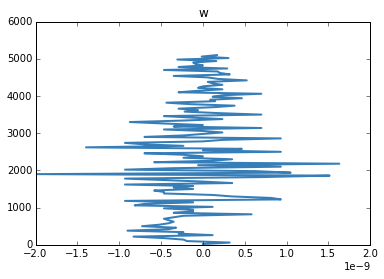

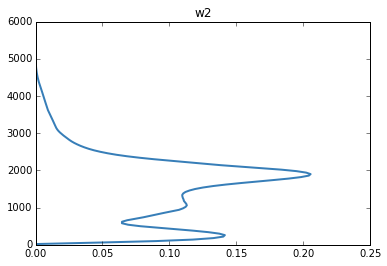

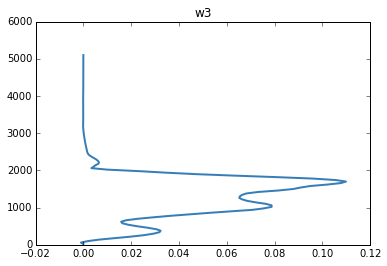

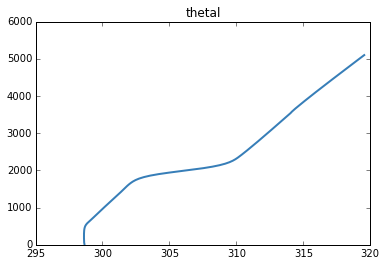

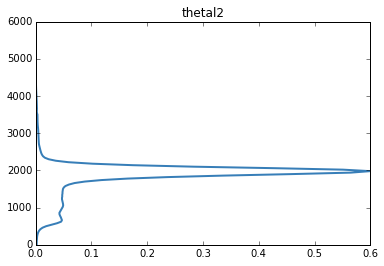

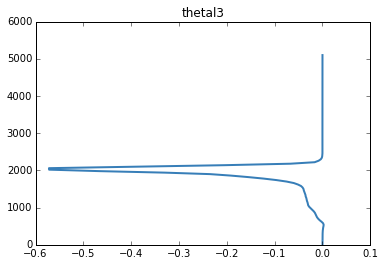

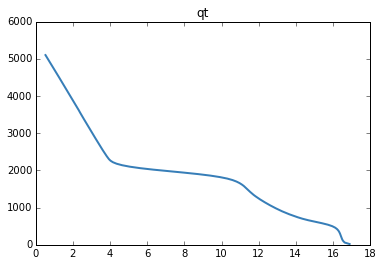

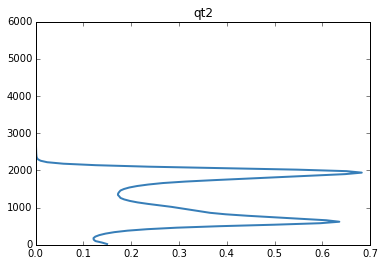

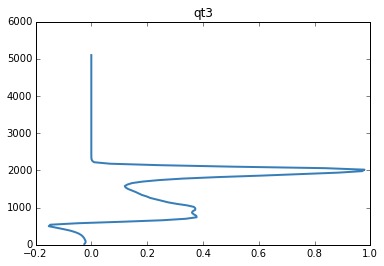

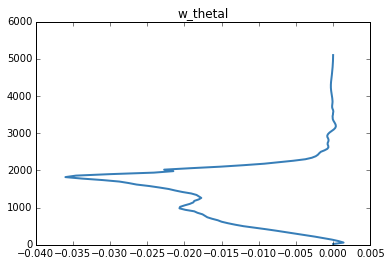

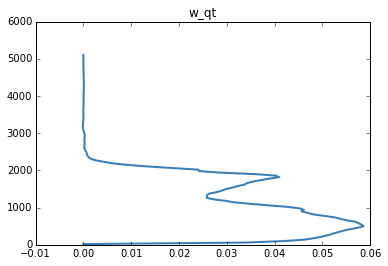

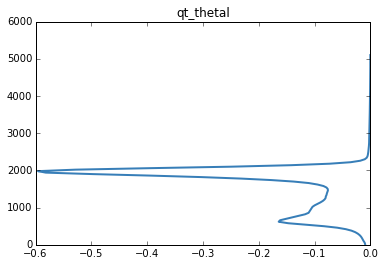

In [14]:
all_inputs = denormalize_input(model_input).reshape(nt, nz, model_input.shape[1])
for i in range(len(input_parameters)):
    plt.figure()
    name = input_parameters[i]
    plt.title(name)
    plt.plot(all_inputs[it, :, i], ds['z'])
    plt.legend()
plt.show()